In [0]:
import pandas as pd
import numpy as np
import string
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MaxAbsScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from tqdm import tqdm

import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
# from gensim.models import Word2Vec
# from gensim.models import KeyedVectors
import pickle

import os

from collections import Counter
from scipy.sparse import hstack

from prettytable import PrettyTable
import warnings
warnings.filterwarnings('ignore')

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')
root_path = '/content/gdrive/My Drive/IRE_Major_Project/'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
data = pd.read_csv(root_path+'preprocessed.csv')

In [4]:
data.head()

,id,tweet,new_tweet,user_mentions,n_hash_tags,n_urls,n_emojis,subtask_a,subtask_b,subtask_c,original_tweet_length,new_tweet_length
0,86426,@USER She should ask a few native Americans wh...,she ask native americans their take be,1,0,0,0,OFF,UNT,NaN,14,7
1,90194,@USER @USER Go home you’re drunk!!! @USER #MAG...,go home you drink maga trump2020,3,2,1,1,OFF,TIN,IND,11,6
2,16820,Amazon is investigating Chinese employees who ...,amazon investigate chinese employees sell inte...,0,5,1,0,NOT,NaN,NaN,27,19
3,62688,"@USER Someone should'veTaken"" this piece of sh...",someone should vetaken piece shit volcano,1,0,0,1,OFF,UNT,NaN,11,6
4,43605,@USER @USER Obama wanted liberals &amp; illega...,obama want liberals amp illegals move red state,2,0,0,0,NOT,NaN,NaN,12,8


In [16]:
data = data[data['subtask_c'].isin(['IND'  , 'GRP' , 'OTH'])]
data.drop(columns=['subtask_a' , 'subtask_b'] , inplace = True)
data.head()

KeyError: ignored

# Splitting Data: Train and Test


In [17]:
Y = data['subtask_c']
X = data.drop(['subtask_c','id'],axis=1)
print("Shape of X: ",X.shape)
print("Shape of Y: ",Y.shape)

Shape of X:  (3876, 8)
Shape of Y:  (3876,)


In [18]:
# data['subtask_a'].value_counts()
data['subtask_c'].value_counts()

IND    2407
GRP    1074
OTH     395
Name: subtask_c, dtype: int64

In [19]:
#separating data into train and test
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size=0.30,stratify=Y, random_state=42)
print("Shape of X_train: ", X_train.shape)
print("Shape of Y_train: ",Y_train.shape)
print("Shape of X_test: ",X_test.shape)
print("Shape of Y_test: ",Y_test.shape)

Shape of X_train:  (2713, 8)
Shape of Y_train:  (2713,)
Shape of X_test:  (1163, 8)
Shape of Y_test:  (1163,)


#### Change the mapping of the label column to binary


In [0]:
Y_train = Y_train.map(dict(IND=0, GRP=1 , OTH= 2))
Y_test = Y_test.map(dict(IND=0, GRP=1 , OTH = 2))

In [0]:
# ## one hot encode y for multiclass  classification 
# from sklearn.preprocessing import label_binarize


# Y_train = label_binarize(Y_train, classes=[0, 1, 2])
# Y_test = label_binarize(Y_test, classes=[0, 1, 2])

In [22]:
print(Y_train.shape)

(2713,)


# Making Data Model Ready: Encoding Tweets

## 1. Bag of Words : Tweets


In [23]:
vectorizer_tweet_bow = CountVectorizer(min_df=5,ngram_range=(1,2))
vectorizer_tweet_bow.fit(X_train['new_tweet'])

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=5,
                ngram_range=(1, 2), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

In [24]:
X_train_tweet_bow = vectorizer_tweet_bow.transform(X_train['new_tweet'])
X_test_tweet_bow = vectorizer_tweet_bow.transform(X_test['new_tweet'])

print("Shape of X_train_tweet_bow ",X_train_tweet_bow.shape)
print("Shape of X_test_tweet_bow ",X_test_tweet_bow.shape)

Shape of X_train_tweet_bow  (2713, 1602)
Shape of X_test_tweet_bow  (1163, 1602)


##2. TF-IDF : Tweets

In [25]:
vectorizer_tweet_tfidf = TfidfVectorizer(min_df=5,ngram_range=(1,2))
vectorizer_tweet_tfidf.fit(X_train['new_tweet'])

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=None,
                min_df=5, ngram_range=(1, 2), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)

In [26]:
X_train_tweet_tfidf = vectorizer_tweet_tfidf.transform(X_train['new_tweet'])
X_test_tweet_tfidf = vectorizer_tweet_tfidf.transform(X_test['new_tweet'])

print("Shape of X_train_tweet_tfidf ",X_train_tweet_tfidf.shape)
print("Shape of X_test_tweet_tfidf ",X_test_tweet_tfidf.shape)

Shape of X_train_tweet_tfidf  (2713, 1602)
Shape of X_test_tweet_tfidf  (1163, 1602)


##3. Avg W2Vec : Tweets

In [0]:
# average Word2Vec
from scipy.sparse import csr_matrix  ## to make data type consistent across all methods


def get_avg_w2v(corpus):
    with open(root_path+'glove_vectors', 'rb') as f:
      model = pickle.load(f)
      glove_words =  set(model.keys())

    avg_w2v_vectors=[]
    for sentence in tqdm(corpus): # for each review/sentence
        vector = np.zeros(300) # as word vectors are of zero length
        cnt_words =0; # num of words with a valid vector in the sentence/review
        for word in sentence.split(): # for each word in a review/sentence
            if word in glove_words:
                vector += model[word]
                cnt_words += 1
        if cnt_words != 0:
            vector /= cnt_words
        avg_w2v_vectors.append(vector)
    return csr_matrix(avg_w2v_vectors)

In [28]:
X_train_tweet_avg_w2v_vectors = get_avg_w2v(X_train['new_tweet'])
X_test_tweet_avg_w2v_vectors = get_avg_w2v(X_test['new_tweet'])

100%|██████████| 1163/1163 [00:00<00:00, 8281.82it/s]


In [29]:

print("Shape of X_train_tweet_avg_w2v_vectors",X_train_tweet_avg_w2v_vectors.shape )
print("Shape of X_test_tweet_avg_w2v_vectors ",X_test_tweet_avg_w2v_vectors.shape )

Shape of X_train_tweet_avg_w2v_vectors (2713, 300)
Shape of X_test_tweet_avg_w2v_vectors  (1163, 300)


# Applying Logistic Regression on different featurization of Tweets

In [0]:
def prRed(skk): print("\033[91m {}\033[00m" .format(skk)) 
def prGreen(skk): print("\033[92m {}\033[00m" .format(skk)) 
def prPurple(skk): print("\033[95m {}\033[00m" .format(skk)) 
def prCyan(skk): print("\033[96m {}\033[00m" .format(skk)) 
def prLighBlue(skk): print("\033[94m {}\033[00m" .format(skk)) 
def prOrange(skk): print("\033[33m {}\033[00m" .format(skk)) 

## 1. BOW



In [0]:
f1 = X_train_tweet_bow
f2 = X_train['user_mentions'].values.reshape(-1,1)
f3 = X_train['n_hash_tags'].values.reshape(-1,1)
f4 = X_train['n_urls'].values.reshape(-1,1)
f5 = X_train['n_emojis'].values.reshape(-1,1)

X_train_bow_lr =hstack((f1,f2,f3,f4,f5))
X_train_bow_lr.shape

(2713, 1606)

In [0]:
f1 = X_test_tweet_bow
f2 = X_test['user_mentions'].values.reshape(-1,1)
f3 = X_test['n_hash_tags'].values.reshape(-1,1)
f4 = X_test['n_urls'].values.reshape(-1,1)
f5 = X_test['n_emojis'].values.reshape(-1,1)

# print(type(f1))
X_test_bow_lr =hstack((f1,f2,f3,f4,f5))
X_test_bow_lr.shape

(1163, 1606)

In [0]:
tune_parameters = [{'C': [10**-4, 10**-2, 10**0, 10**2, 10**4]}]

#Using GridSearchCV
model = GridSearchCV(LogisticRegression(class_weight='balanced', solver = 'lbfgs'), tune_parameters, scoring = "f1_micro", cv=10, return_train_score=True,n_jobs=-1, verbose=True)
model.fit(X_train_bow_lr, Y_train)

Fitting 10 folds for each of 5 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    8.8s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    9.6s finished


GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight='balanced',
                                          dual=False, fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid=[{'C': [0.0001, 0.01, 1, 100, 10000]}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='f1_micro', verbose=True)

In [0]:
model.best_estimator_

LogisticRegression(C=0.01, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

Due to class imbalance ( in one vs all setup ) we will consider micro averaging  of F1 score .
Average F1 score for training : 0.7121267969037965
Average F1 score for testing : 0.6603611349957008

Original size of samples  :  
 0    722
1    322
2    119
Name: subtask_c, dtype: int64


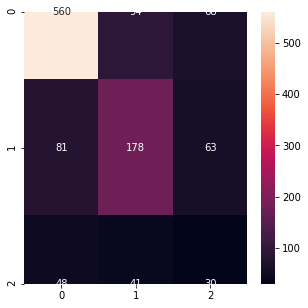

In [0]:
lr_bow = LogisticRegression(C=0.01 , class_weight='balanced',  solver='lbfgs' )
lr_bow.fit(X_train_bow_lr,Y_train)

# contains probabilities
y_train_pred = lr_bow.predict_proba(X_train_bow_lr)
y_test_pred = lr_bow.predict_proba(X_test_bow_lr)

## highest probability term 
y_test_pred_class =  np.argmax(y_test_pred,  axis = 1)
y_train_pred_class = np.argmax(y_train_pred, axis = 1)

print("Due to class imbalance ( in one vs all setup ) we will consider micro averaging  of F1 score .")
print("Average F1 score for training :" , f1_score(Y_train.values, y_train_pred_class , average = "micro"))
print("Average F1 score for testing :"  ,f1_score(Y_test.values, y_test_pred_class ,average = "micro"))

print("\nOriginal size of samples  :  \n" ,Y_test.value_counts())
results = confusion_matrix(Y_test.values, y_test_pred_class)
plt.figure(figsize = (5,5))
sns.heatmap(results, annot=True,  fmt='g')

#old Average F1 score for training : 0.7032805012900848
#Average F1 score for testing : 0.6698194325021496

### Misclassified examples

In [0]:
y_test_predict = y_test_pred_class
y_test = np.asarray(Y_test)
misclassified = np.where(y_test != y_test_predict)

In [0]:
def print_stuff(idx):
  global y_test_pred # has probabilities
  global X_test
  global y_test # class
  # preprocessed_tweet
  print('preprocessed tweet')
  print(X_test.iloc[idx,1])
  # computed prob
  print('computed prob: ',y_test_pred[idx])
  print('original class: ',y_test[idx])

In [0]:
# print(type(misclassified))
print(len(misclassified[0]), 'misclassifications')

395 misclassifications


Red: original individual insult (0), classified as group (1)<br>
Green: original individual insult (0), classified as other (2)<br>
Purple: original group insult (1), classified as individual (0) <br>
Cyan: original group insult (1), classified as other (2)<br>
Light Blue: original other insult (2), classified as individual (0) <br>
Orange: original other insult (2), classified as group (1)

In [0]:
#IND=0, GRP=1 , OTH= 2
counts = [0] * 6
limit=5

for index in misclassified[0]:
  if limit in counts:
    break
  #original individual insult (0), classified as group (1)
  if y_test[index] == 0 and y_test_predict[index] == 1:
    prRed(X_test.iloc[index,0])
    print_stuff(index)
    counts[0] += 1
  #original individual insult (0), classified as other (2)
  elif y_test[index] == 0 and y_test_predict[index] == 2:
    prGreen(X_test.iloc[index,0])
    print_stuff(index)
    counts[1] += 1
  #original group insult (1), classified as individual (0)
  elif y_test[index] == 1 and y_test_predict[index] == 0:
    prPurple(X_test.iloc[index,0])
    print_stuff(index)
    counts[2] += 1
  #original group insult (1), classified as other (2)
  elif y_test[index] == 1 and y_test_predict[index] == 2:
    prCyan(X_test.iloc[index,0])
    print_stuff(index)
    counts[3] += 1
  #original other insult (2), classified as individual (0)
  elif y_test[index] == 2 and y_test_predict[index] == 0:
    prLighBlue(X_test.iloc[index,0])
    print_stuff(index)
    counts[4] += 1
  #original other insult (2), classified as group (1)
  elif y_test[index] == 2 and y_test_predict[index] == 1:
    prOrange(X_test.iloc[index,0])
    print_stuff(index)
    counts[5] += 1

 @USER //xD Well the suffering she goes through and all the terrible shit she sees ends up making her pretty insane (I think you already seen that from certain things I posted XD) but hey at least she's only insane to bad guys!
preprocessed tweet
xd well suffer she go terrible shit she see end make her pretty insane i think you already see certain things i post xd hey least she s insane bad guy
computed prob:  [0.69771634 0.16546691 0.13681676]
original class:  1
 @USER @USER @USER Oh and higher unemployment and witch hunts and lynch mobs and antifa communist parades ...you can have all that shit and let Hollywood decide how you feel.
preprocessed tweet
oh higher unemployment witch hunt lynch mob antifa communist parade you shit let hollywood decide you feel
computed prob:  [0.41707155 0.28372152 0.29920694]
original class:  2
 @USER @USER @USER Lil girl we having an adult conversation so take your thin ass on somewhere ya dig
preprocessed tweet
lil girl we adult conversation take your

### Following scoring is based on 1 vs all methodology

In [0]:
train_truth_class0 =  np.where(Y_train.values == 0  ,1 , 0)
train_class0 = np.where( y_train_pred_class == 0 ,1 , 0)
test_class0 = np.where( y_test_pred_class == 0 ,1 , 0)
test_truth_class0 =  np.where(Y_test.values == 0  ,1 , 0)


train_truth_class1 =  np.where(Y_train.values == 1  ,1 , 0)
train_class1 = np.where(y_train_pred_class == 1 ,1 , 0) 
test_class1 = np.where(y_test_pred_class == 1 ,1 , 0) 
test_truth_class1 =  np.where(Y_test.values == 1  ,1 , 0)



train_truth_class2 =  np.where(Y_train.values == 2  ,1 , 0)
train_class2 = np.where( y_train_pred_class == 2 ,1 , 0) 
test_class2 = np.where( y_test_pred_class == 2 ,1 , 0) 
test_truth_class2 =  np.where(Y_test.values == 2  ,1 , 0)


### class 0 : IND score

training F1 score of class 0 :  0.8088997256933861
testing F1 score of class 0 :  0.7937632884479093


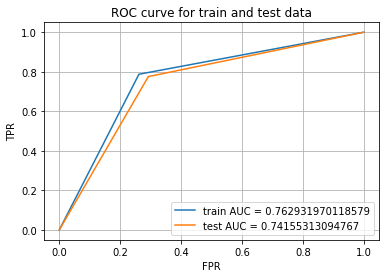

In [0]:
print("training F1 score of class 0 : "  ,  f1_score(train_truth_class0, train_class0))
print("testing F1 score of class 0 : "  ,  f1_score(test_truth_class0, test_class0))


train_fpr, train_tpr, tr_thresholds = roc_curve(train_truth_class0, train_class0)
test_fpr, test_tpr, te_thresholds = roc_curve(test_truth_class0, test_class0)

plt.plot(train_fpr, train_tpr, label="train AUC = "+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC = "+str(auc(test_fpr, test_tpr)))
plt.legend()

plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC curve for train and test data")
plt.grid()
plt.show()
#old training F1 score of class 0 :  0.8008360704687967
#testing F1 score of class 0 :  0.7911784975878704

### class 1 : GRP score

training F1 score of class 1 :  0.6372613561553654
testing F1 score of class 1 :  0.5606299212598425


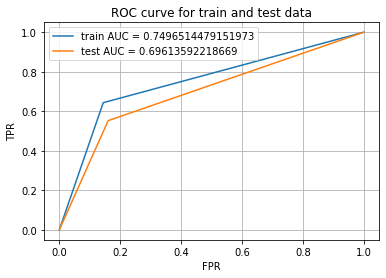

In [0]:
print("training F1 score of class 1 : "  ,  f1_score(train_truth_class1, train_class1))
print("testing F1 score of class 1 : "  ,  f1_score(test_truth_class1, test_class1))


train_fpr, train_tpr, tr_thresholds = roc_curve(train_truth_class1, train_class1)
test_fpr, test_tpr, te_thresholds = roc_curve(test_truth_class1, test_class1)

plt.plot(train_fpr, train_tpr, label="train AUC = "+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC = "+str(auc(test_fpr, test_tpr)))
plt.legend()

plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC curve for train and test data")
plt.grid()
plt.show()
#old training F1 score of class 1 :  0.6260869565217392
#testing F1 score of class 1 :  0.5608974358974359

### class 2 : OTH

training F1 score of class 2 :  0.3865814696485623
testing F1 score of class 2 :  0.21428571428571427


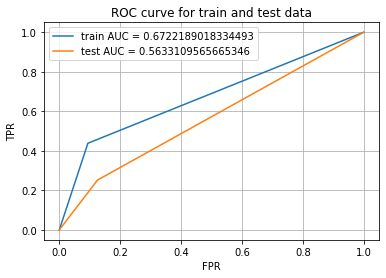

In [0]:
print("training F1 score of class 2 : "  ,  f1_score(train_truth_class2, train_class2))
print("testing F1 score of class 2 : "  ,  f1_score(test_truth_class2, test_class2))


train_fpr, train_tpr, tr_thresholds = roc_curve(train_truth_class2, train_class2)
test_fpr, test_tpr, te_thresholds = roc_curve(test_truth_class2, test_class2)

plt.plot(train_fpr, train_tpr, label="train AUC = "+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC = "+str(auc(test_fpr, test_tpr)))
plt.legend()

plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC curve for train and test data")
plt.grid()
plt.show()
#old training F1 score of class 2 :  0.3402061855670103
#testing F1 score of class 2 :  0.2390438247011952

## 2. TF-IDF


In [31]:
f1 = X_train_tweet_tfidf
f2 = X_train['user_mentions'].values.reshape(-1,1)
f3 = X_train['n_hash_tags'].values.reshape(-1,1)
f4 = X_train['n_urls'].values.reshape(-1,1)
f5 = X_train['n_emojis'].values.reshape(-1,1)
f6 = X_train['new_tweet_length'].values.reshape(-1,1)
f7 = X_train['original_tweet_length'].values.reshape(-1,1)
# print(type(f1))
X_train_tfidf =hstack((f1,f2,f3,f4,f5,f6,f7))
X_train_tfidf.shape

(2713, 1608)

In [32]:
f1 = X_test_tweet_tfidf
f2 = X_test['user_mentions'].values.reshape(-1,1)
f3 = X_test['n_hash_tags'].values.reshape(-1,1)
f4 = X_test['n_urls'].values.reshape(-1,1)
f5 = X_test['n_emojis'].values.reshape(-1,1)
f6 = X_test['new_tweet_length'].values.reshape(-1,1)
f7 = X_test['original_tweet_length'].values.reshape(-1,1)
X_test_tfidf =hstack((f1,f2,f3,f4,f5,f6,f7))
X_test_tfidf.shape

(1163, 1608)

              precision    recall  f1-score   support

           0       0.81      0.75      0.78       722
           1       0.52      0.62      0.57       322
           2       0.17      0.17      0.17       119

    accuracy                           0.65      1163
   macro avg       0.50      0.51      0.51      1163
weighted avg       0.67      0.65      0.66      1163



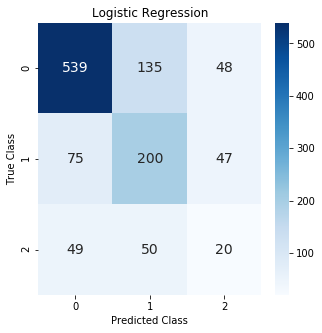

In [36]:
lr_tfidf = LogisticRegression(C=0.1 , class_weight='balanced',  solver='lbfgs' )
lr_tfidf.fit(X_train_tfidf,Y_train)

y_train_pred = lr_tfidf.predict_proba(X_train_tfidf)
y_test_pred = lr_tfidf.predict_proba(X_test_tfidf)


## highest probability term 
y_test_pred_class =  np.argmax(y_test_pred,  axis = 1)
y_train_pred_class = np.argmax(y_train_pred, axis = 1)



# print("Due to class imbalance ( in one vs all setup ) we will consider micro averaging  of F1 score .")
# print("Average F1 score for training :" , f1_score(Y_train.values, y_train_pred_class , average = "micro"))
# print("Average F1 score for testing :"  ,f1_score(Y_test.values, y_test_pred_class ,average = "micro"))


# print("\nOriginal size of samples  :  \n" ,Y_test.value_counts())
results = confusion_matrix(Y_test.values, y_test_pred_class)
print(classification_report(Y_test, y_test_pred_class))
%matplotlib inline
plt.figure(figsize = (5,5))
ax = sns.heatmap(results, cmap="Blues", annot=True,annot_kws={"size": 14},fmt='g')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.title('Logistic Regression')
plt.ylabel('True Class')
plt.xlabel('Predicted Class')
plt.show()

### Misclassified examples

In [0]:
y_test_predict = y_test_pred_class
y_test = np.asarray(Y_test)
misclassified = np.where(y_test != y_test_predict)

In [0]:
# print(type(misclassified))
print(len(misclassified[0]), 'misclassifications')

404 misclassifications


Red: original individual insult (0), classified as group (1)<br>
Green: original individual insult (0), classified as other (2)<br>
Purple: original group insult (1), classified as individual (0) <br>
Cyan: original group insult (1), classified as other (2)<br>
Light Blue: original other insult (2), classified as individual (0) <br>
Orange: original other insult (2), classified as group (1)

In [0]:
#IND=0, GRP=1 , OTH= 2
counts = [0] * 6
limit=5

for index in misclassified[0]:
  if limit in counts:
    break
  #original individual insult (0), classified as group (1)
  if y_test[index] == 0 and y_test_predict[index] == 1:
    prRed(X_test.iloc[index,0])
    print_stuff(index)
    counts[0] += 1
  #original individual insult (0), classified as other (2)
  elif y_test[index] == 0 and y_test_predict[index] == 2:
    prGreen(X_test.iloc[index,0])
    print_stuff(index)
    counts[1] += 1
  #original group insult (1), classified as individual (0)
  elif y_test[index] == 1 and y_test_predict[index] == 0:
    prPurple(X_test.iloc[index,0])
    print_stuff(index)
    counts[2] += 1
  #original group insult (1), classified as other (2)
  elif y_test[index] == 1 and y_test_predict[index] == 2:
    prCyan(X_test.iloc[index,0])
    print_stuff(index)
    counts[3] += 1
  #original other insult (2), classified as individual (0)
  elif y_test[index] == 2 and y_test_predict[index] == 0:
    prLighBlue(X_test.iloc[index,0])
    print_stuff(index)
    counts[4] += 1
  #original other insult (2), classified as group (1)
  elif y_test[index] == 2 and y_test_predict[index] == 1:
    prOrange(X_test.iloc[index,0])
    print_stuff(index)
    counts[5] += 1

 @USER @USER @USER @USER @USER @USER @USER @USER @USER @USER @USER @USER @USER @USER @USER @USER @USER @USER @USER @USER @USER @USER @USER @USER @USER @USER @USER @USER @USER @USER @USER @USER @USER @USER @USER @USER @USER @USER @USER @USER @USER @USER @USER @USER @USER @USER @USER @USER @USER @USER now you touched visa-mata's raw nerve by saying modi for 2019" thats why she may block you soon  she is having wild/wet dream of being PM after modi fail to get full majority in 2019.  please dont wake her up from her dream of bhajpaa getting 160 seat in 2014"
preprocessed tweet
you touch visa mata s raw nerve say modi 2019 thats she may block you soon she wild wet dream pm modi fail get full majority 2019 please dont wake her her dream bhajpaa get 160 seat 2014
computed prob:  [0.26168956 0.47228855 0.26602189]
original class:  0
 @USER //xD Well the suffering she goes through and all the terrible shit she sees ends up making her pretty insane (I think you already seen that from certain th

## 3. AvgW2Vec 

In [0]:
f1 = X_train_tweet_avg_w2v_vectors
f2 = X_train['user_mentions'].values.reshape(-1,1)
f3 = X_train['n_hash_tags'].values.reshape(-1,1)
f4 = X_train['n_urls'].values.reshape(-1,1)
f5 = X_train['n_emojis'].values.reshape(-1,1)
f6 = X_train['new_tweet_length'].values.reshape(-1,1)
f7 = X_train['original_tweet_length'].values.reshape(-1,1)
X_train_w2vec =hstack((f1,f2,f3,f4,f5,f6,f7))
X_train_w2vec.shape

(2713, 306)

In [0]:
f1 = X_test_tweet_avg_w2v_vectors
f2 = X_test['user_mentions'].values.reshape(-1,1)
f3 = X_test['n_hash_tags'].values.reshape(-1,1)
f4 = X_test['n_urls'].values.reshape(-1,1)
f5 = X_test['n_emojis'].values.reshape(-1,1)
f6 = X_test['new_tweet_length'].values.reshape(-1,1)
f7 = X_test['original_tweet_length'].values.reshape(-1,1)
X_test_w2vec =hstack((f1,f2,f3,f4,f5,f6,f7))
X_test_w2vec.shape

(1163, 306)

Due to class imbalance ( in one vs all setup ) we will consider micro averaging  of F1 score .
Average F1 score for training : 0.6288241798746774
Average F1 score for testing : 0.6087704213241617

Original size of samples  :  
 0    722
1    322
2    119
Name: subtask_c, dtype: int64


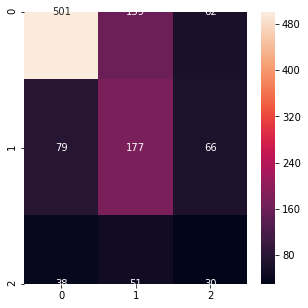

In [0]:
lr_w2vec = LogisticRegression(C= 0.01, class_weight='balanced',  solver='lbfgs' )
lr_w2vec.fit(X_train_w2vec,Y_train)

y_train_pred = lr_w2vec.predict_proba(X_train_w2vec)
y_test_pred = lr_w2vec.predict_proba(X_test_w2vec)


## highest probability term 
y_test_pred_class =  np.argmax(y_test_pred,  axis = 1)
y_train_pred_class = np.argmax(y_train_pred, axis = 1)



print("Due to class imbalance ( in one vs all setup ) we will consider micro averaging  of F1 score .")
print("Average F1 score for training :" , f1_score(Y_train.values, y_train_pred_class , average = "micro"))
print("Average F1 score for testing :"  ,f1_score(Y_test.values, y_test_pred_class ,average = "micro"))


print("\nOriginal size of samples  :  \n" ,Y_test.value_counts())
results = confusion_matrix(Y_test.values, y_test_pred_class)
plt.figure(figsize = (5,5))
sns.heatmap(results, annot=True,  fmt='g')


#old Average F1 score for training : 0.6030224843346849
#Average F1 score for testing : 0.5760963026655203

### Misclassified examples

In [0]:
y_test_predict = y_test_pred_class
y_test = np.asarray(Y_test)
misclassified = np.where(y_test != y_test_predict)

In [0]:
# print(type(misclassified))
print(len(misclassified[0]), 'misclassifications')

455 misclassifications


Red: original individual insult (0), classified as group (1)<br>
Green: original individual insult (0), classified as other (2)<br>
Purple: original group insult (1), classified as individual (0) <br>
Cyan: original group insult (1), classified as other (2)<br>
Light Blue: original other insult (2), classified as individual (0) <br>
Orange: original other insult (2), classified as group (1)

In [0]:
#IND=0, GRP=1 , OTH= 2
counts = [0] * 6
limit=5

for index in misclassified[0]:
  if limit in counts:
    break
  #original individual insult (0), classified as group (1)
  if y_test[index] == 0 and y_test_predict[index] == 1:
    prRed(X_test.iloc[index,0])
    print_stuff(index)
    counts[0] += 1
  #original individual insult (0), classified as other (2)
  elif y_test[index] == 0 and y_test_predict[index] == 2:
    prGreen(X_test.iloc[index,0])
    print_stuff(index)
    counts[1] += 1
  #original group insult (1), classified as individual (0)
  elif y_test[index] == 1 and y_test_predict[index] == 0:
    prPurple(X_test.iloc[index,0])
    print_stuff(index)
    counts[2] += 1
  #original group insult (1), classified as other (2)
  elif y_test[index] == 1 and y_test_predict[index] == 2:
    prCyan(X_test.iloc[index,0])
    print_stuff(index)
    counts[3] += 1
  #original other insult (2), classified as individual (0)
  elif y_test[index] == 2 and y_test_predict[index] == 0:
    prLighBlue(X_test.iloc[index,0])
    print_stuff(index)
    counts[4] += 1
  #original other insult (2), classified as group (1)
  elif y_test[index] == 2 and y_test_predict[index] == 1:
    prOrange(X_test.iloc[index,0])
    print_stuff(index)
    counts[5] += 1

 @USER @USER @USER @USER @USER @USER @USER @USER @USER @USER @USER @USER @USER @USER @USER @USER @USER @USER @USER @USER @USER @USER @USER @USER @USER @USER @USER @USER @USER @USER @USER @USER @USER @USER @USER @USER @USER @USER @USER @USER @USER @USER @USER @USER @USER @USER @USER @USER @USER @USER now you touched visa-mata's raw nerve by saying modi for 2019" thats why she may block you soon  she is having wild/wet dream of being PM after modi fail to get full majority in 2019.  please dont wake her up from her dream of bhajpaa getting 160 seat in 2014"
preprocessed tweet
you touch visa mata s raw nerve say modi 2019 thats she may block you soon she wild wet dream pm modi fail get full majority 2019 please dont wake her her dream bhajpaa get 160 seat 2014
computed prob:  [0.21042992 0.47094752 0.31862256]
original class:  0
 @USER //xD Well the suffering she goes through and all the terrible shit she sees ends up making her pretty insane (I think you already seen that from certain th